In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.coronography.lyot_coronographs import  LyotCoronograph#, KnifeEdgeCoronograph
from ekarus.coronography.phase_mask_coronographs import FourQuadrantCoronograph, VectorVortexCoronograph, PerfectCoronograph
from ekarus.coronography.apodization_coronographs import ApodizerPhasePlateCoronograph, PAPLC
from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def imageShow(image2d, pixelSize=1, title='',
              xlabel=r'$\lambda/D$', ylabel=r'$\lambda/D$', zlabel=''):
    sz=image2d.shape
    plt.imshow(xp.asnumpy(image2d), 
               extent=[-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
                -sz[1]/2*pixelSize, sz[1]/2*pixelSize],
                cmap='twilight',vmin=-24)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar= plt.colorbar()
    cbar.ax.set_ylabel(zlabel)

def showZoomCenter(image, pixelSize, maxLogVal = None, **kwargs):
    '''show log(image) zoomed around center'''
    imageHalfSizeInPoints= image.shape[0]/2
    roi= [int(imageHalfSizeInPoints*0.8), int(imageHalfSizeInPoints*1.2)]
    imageZoomedLog= xp.log(image[roi[0]: roi[1], roi[0]:roi[1]])
    if maxLogVal is None:
        maxLogVal = xp.max(imageZoomedLog)
    imageZoomedLog -= maxLogVal
    imageShow(imageZoomedLog, pixelSize=pixelSize, **kwargs)

In [ ]:
def show_coronograph_prop(coro, maxLogPsf=None):
    plt.figure(figsize=(22,4))
    plt.subplot(1,4,1)
    fcmap = 'RdBu' if xp.max(coro.focal_mask) > 1.0 else 'grey'
    phase = xp.angle(xp.exp(1j*coro.focal_mask))
    phase += 2*xp.pi * (phase < 0.0)
    plt.imshow(xp.asnumpy(phase),cmap=fcmap,origin='lower')
    plt.title('Focal plane mask')
    plt.colorbar()
    plt.subplot(1,4,2)
    showZoomCenter(xp.abs(coro._focal_field)**2,1/coro.oversampling,title='PSF at focal mask',maxLogVal=maxLogPsf)
    plt.subplot(1,4,3)
    plt.imshow(xp.asnumpy(coro.pupil_mask),cmap='grey',origin='lower')
    plt.title('Pupil stop')
    plt.colorbar()
    plt.subplot(1,4,4)
    showZoomCenter(xp.abs(coro._focal_coro_field)**2,1/coro.oversampling,title='Coronographic PSF',maxLogVal=maxLogPsf)


In [4]:
ssao = SingleStageAO(tn='high_contrast')
ssaom = SingleStageAO(tn='ekarus_42x42')
ssao.initialize_turbulence(tn='ekarus_10cm')

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Unobscured actuators: 436/468
Fried parameter is: 10.0 [cm] (seeing = 1.01")


In [5]:
phase = ssao.get_phasescreen_at_time(0.2)
cmask = ssao.cmask.copy()
amp = 50e-9

phi = phase[~cmask]
phi *= amp/xp.std(phi)

X,Y = image_grid(cmask.shape,recenter=True)
tip = X[~cmask]
tilt = Y[~cmask]
piston = xp.ones(int(xp.sum(1-cmask)))
ptt = xp.vstack([piston,tip,tilt]).T
phase2ptt = xp.linalg.pinv(ptt)

ptt_coeffs = phase2ptt @ phi
ptt_phi = ptt @ ptt_coeffs
phi_filt = reshape_on_mask(phi - ptt_phi,cmask)

lambdaInM = 700e-9
oversampling = 12

input_field = (1-cmask) * xp.exp(1j*phi_filt*2*xp.pi/lambdaInM,dtype=xp.complex64)
pad_width = int(max(input_field.shape)*(oversampling-1))//2
padded_field = xp.pad(input_field,pad_width=pad_width,mode='constant',constant_values=0.0)
psf = abs(xp.fft.fftshift(xp.fft.fft2(padded_field)))**2

maxLogPsf = xp.max(xp.log(psf))

plt.figure(figsize=(22,4))
plt.subplot(1,4,1)
plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(phi,cmask)),mask=xp.asnumpy(cmask)),origin='lower',cmap='RdBu')
plt.title('Phase')
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(masked_array(xp.asnumpy(reshape_on_mask(ptt_phi,cmask)),mask=xp.asnumpy(cmask)),origin='lower',cmap='RdBu')
plt.title('PTT fit')
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(masked_array(xp.asnumpy(phi_filt),mask=xp.asnumpy(cmask)),origin='lower',cmap='RdBu')
plt.title('PTT filtered phase')
plt.colorbar()
plt.subplot(1,4,4)
showZoomCenter(psf, 1/oversampling, maxLogVal=maxLogPsf, title='Non-coronographic PSF')

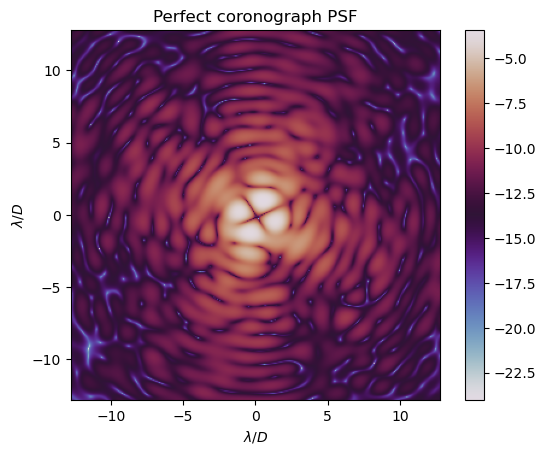

In [6]:
lyot = LyotCoronograph(referenceLambdaInM=lambdaInM,
                       inFocalStopInLambdaOverD=2.0, 
                       outPupilStopInFractionOfPupil=0.95, 
                       outFocalStopInLambdaOverD=50)
perfCoro = PerfectCoronograph()
kedge = LyotCoronograph(referenceLambdaInM=lambdaInM,
                       inFocalStopInLambdaOverD=2.0, 
                       outPupilStopInFractionOfPupil=0.95, 
                       knife_egde=True)
fquad = FourQuadrantCoronograph(referenceLambdaInM=lambdaInM,
                                outPupilStopInFractionOfPupil=0.95)
vortex = VectorVortexCoronograph(referenceLambdaInM=lambdaInM, charge=6)#,
                        #    addInVortex=True,outPupilStopInFractionOfPupil=0.95)

lyot_psf = lyot.get_coronographic_psf(input_field, oversampling, lambdaInM)
perfect_coro_psf = perfCoro.get_coronographic_psf(input_field, oversampling, lambdaInM)
kedge_psf = kedge.get_coronographic_psf(input_field,oversampling, lambdaInM)
fquad_psf = fquad.get_coronographic_psf(input_field,oversampling, lambdaInM)
vortex_psf = vortex.get_coronographic_psf(input_field,oversampling, lambdaInM)


plt.figure(figsize=(22,4))
plt.subplot(1,4,1)
showZoomCenter(vortex_psf, 1/oversampling, maxLogVal=maxLogPsf, title='Vortex coronograph PSF')
plt.subplot(1,4,2)
showZoomCenter(lyot_psf, 1/oversampling, maxLogVal=maxLogPsf, title='Lyot coronograph PSF')
plt.subplot(1,4,3)
showZoomCenter(kedge_psf, 1/oversampling, maxLogVal=maxLogPsf, title='Knife edge coronograph PSF')
plt.subplot(1,4,4)
showZoomCenter(fquad_psf, 1/oversampling, maxLogVal=maxLogPsf, title='4-quadrant coronograph PSF')

plt.figure()
showZoomCenter(perfect_coro_psf, 1/oversampling, maxLogVal=maxLogPsf, title='Perfect coronograph PSF')

In [7]:
# print(xp.sum(lyot_psf)/xp.sum(psf), xp.sum(kedge_psf)/xp.sum(psf), xp.sum(fquad_psf)/xp.sum(psf), xp.sum(vortex_psf)/xp.sum(psf))

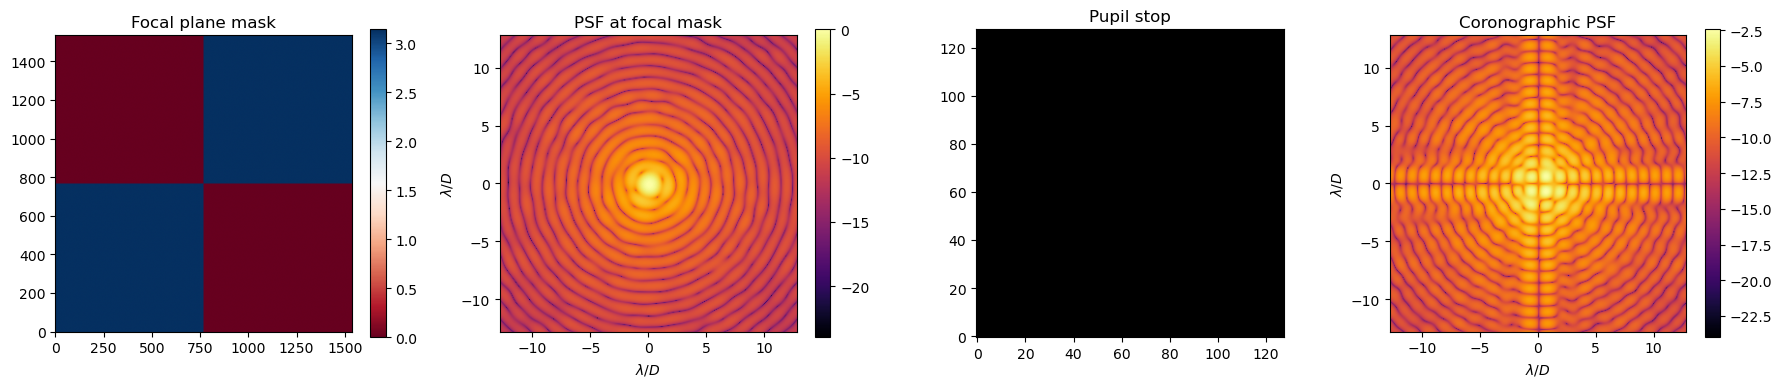

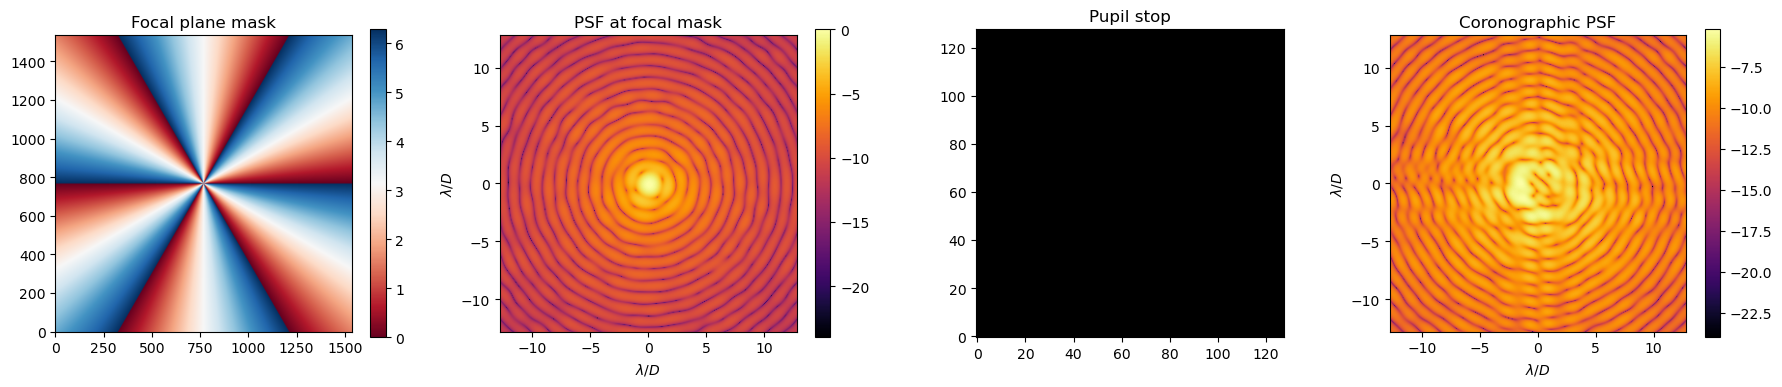

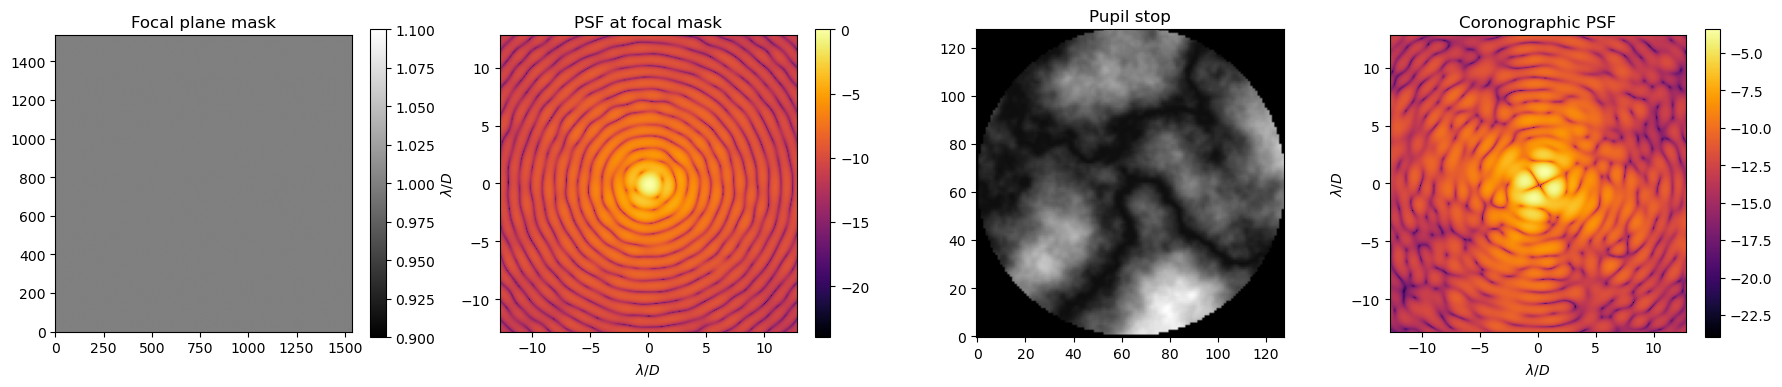

In [8]:
lyot.show_coronograph_prop(maxLogPsf)
kedge.show_coronograph_prop(maxLogPsf)
fquad.show_coronograph_prop(maxLogPsf)
vortex.show_coronograph_prop(maxLogPsf)
perfCoro.show_coronograph_prop(maxLogPsf)

In [ ]:
full_pupil = ssao.cmask.copy()
ekarus_pupil = ssaom.cmask.copy()

APP = ApodizerPhasePlateCoronograph(referenceLambdaInM=750e-9, pupil=ekarus_pupil,
                        contrastInDarkHole=1e-5, iwaInLambdaOverD=2.5, 
                        owaInLambdaOverD=7, oversampling=oversampling)

fullAPP = ApodizerPhasePlateCoronograph(referenceLambdaInM=750e-9, pupil=full_pupil,
                        contrastInDarkHole=1e-5, iwaInLambdaOverD=2.5, 
                        owaInLambdaOverD=7, oversampling=oversampling)

Apodizer computed: average contrast in dark hole is -5.6, Strehl is 48.58%
Apodizer computed: average contrast in dark hole is -6.5, Strehl is 60.29%


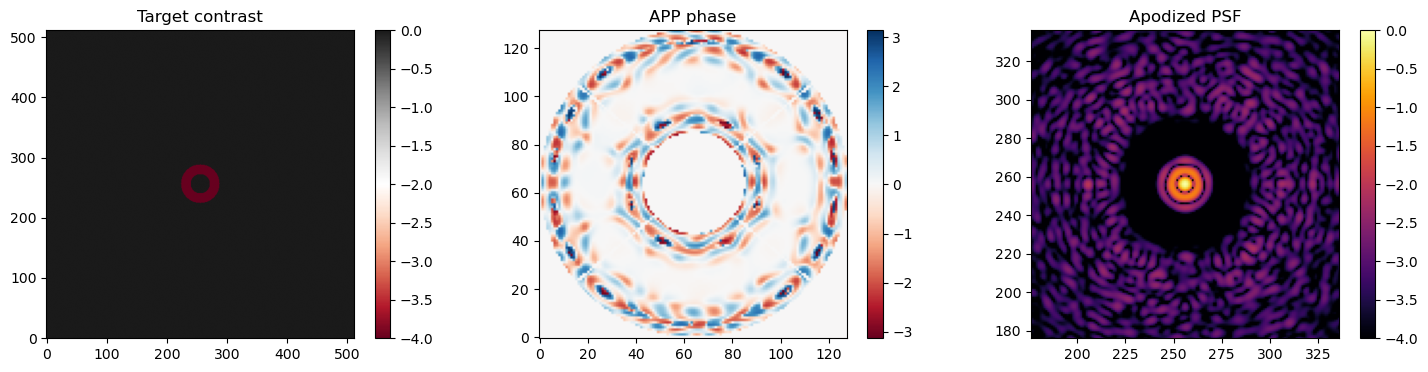

In [ ]:
sympaplc = PAPLC(referenceLambdaInM=lambdaInM, pupil=ekarus_pupil, contrastInDarkHole=1e-4,
              iwaInLambdaOverD=4, owaInLambdaOverD=8, fpmIWAInLambdaOverD=1.5, beta=0.2,
              fpmOWAInLambdaOverD=40, inPupilStopInFractionOfPupil=0.3, symmetric=True, oversampling=4)

paplc = PAPLC(referenceLambdaInM=lambdaInM, pupil=ekarus_pupil, contrastInDarkHole=4e-5,
              iwaInLambdaOverD=2, owaInLambdaOverD=7, fpmIWAInLambdaOverD=2,
              inPupilStopInFractionOfPupil=0.3, oversampling=4, knife_edge=True)

In [ ]:
oversampling=4
ekarus_field = (1-ekarus_pupil) * xp.exp(1j*phi_filt*2*xp.pi/lambdaInM*0,dtype=xp.complex64)
pad_width = int(max(ekarus_field.shape)*(oversampling-1))//2
padded_field = xp.pad(ekarus_field,pad_width=pad_width,mode='constant',constant_values=0.0)
psf = abs(xp.fft.fftshift(xp.fft.fft2(padded_field)))**2
maxLogPsf = xp.max(xp.log(psf))

In [ ]:
sympaplc.get_coronographic_psf(ekarus_field, oversampling, lambdaInM)
paplc.get_coronographic_psf(ekarus_field, oversampling, lambdaInM)

array([[2.23771836e+02, 1.58740091e+02, 6.57499781e+01, ...,
        1.47864110e+01, 1.06631709e+02, 2.03687598e+02],
       [1.59194362e+02, 1.14584545e+02, 4.89779131e+01, ...,
        7.86883243e+00, 7.18465436e+01, 1.42697704e+02],
       [3.58261134e+01, 2.76098230e+01, 1.37304497e+01, ...,
        4.22294143e-02, 1.13912215e+01, 2.95584453e+01],
       ...,
       [1.51141586e+01, 1.00071903e+01, 3.12235309e+00, ...,
        1.27350878e+01, 1.41460239e+01, 1.58614636e+01],
       [2.45448800e+01, 1.80273322e+01, 8.14191941e+00, ...,
        1.91316217e-01, 7.02282598e+00, 2.03254083e+01],
       [1.45755976e+02, 1.03512926e+02, 4.29202457e+01, ...,
        6.52677763e+00, 6.54229791e+01, 1.31167937e+02]], shape=(512, 512))

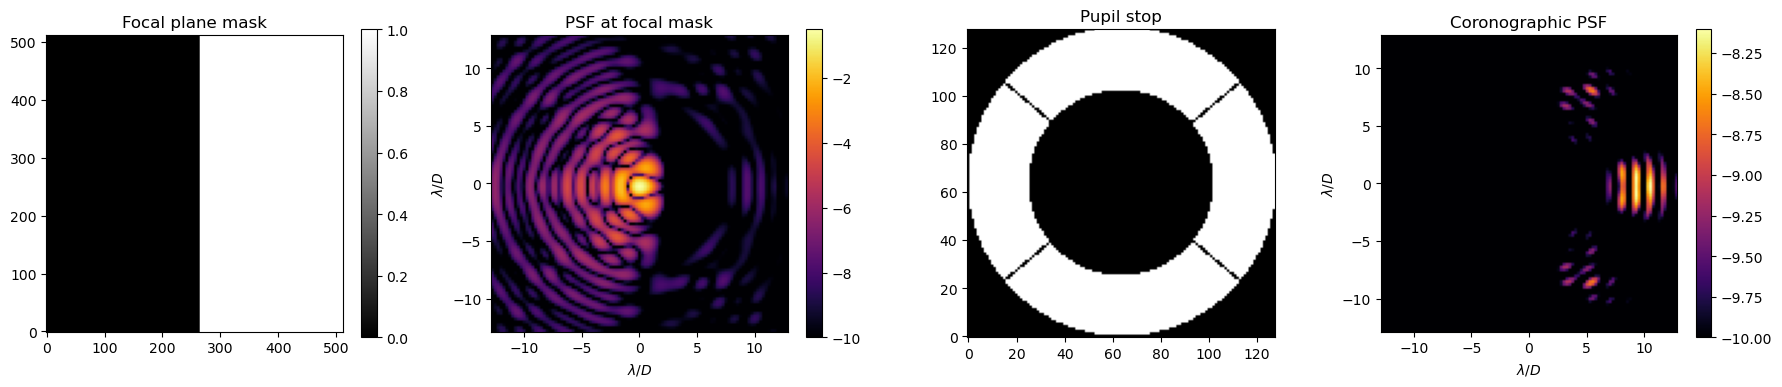

In [ ]:
sympaplc.show_coronograph_prop(maxLogPsf,minVal=-10)
paplc.show_coronograph_prop(maxLogPsf,minVal=-10)